<a href="https://colab.research.google.com/github/sayakpaul/Supervised-Contrastive-Learning-in-TensorFlow-2/blob/master/Contrastive_Training_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## References:
- https://arxiv.org/pdf/2004.11362.pdf
- https://towardsdatascience.com/contrastive-loss-for-supervised-classification-224ae35692e7

## Initial setup

In [0]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
!nvidia-smi

Thu May 28 06:26:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip -q
import wandb
wandb.login()

In [0]:
!wget https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py

## Flowers dataset

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tqdm.notebook import tqdm
from wandb.keras import WandbCallback
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import losses
import time

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

In [0]:
import os
os.environ['WANDB_DISABLE_CODE'] = 'True'

In [0]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


In [0]:
# Visualization
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis("off")

### Data pipeline

In [0]:
IMG_SHAPE = 128
BS = 64
AUTO = tf.data.experimental.AUTOTUNE

@tf.function
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))

    return (image, label)

train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

## Model building

In [0]:
# Reference: https://github.com/wangz10/contrastive_loss/blob/master/model.py
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [0]:
# Encoder Network
def encoder_net():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	normalization_layer = UnitNormLayer()

	encoder = tf.keras.applications.ResNet50(weights=None, include_top=False)
	encoder.trainable = True

	embeddings = encoder(inputs, training=True)
	embeddings = GlobalAveragePooling2D()(embeddings)
	norm_embeddings = normalization_layer(embeddings)

	encoder_network = Model(inputs, norm_embeddings)

	return encoder_network

# Projector Network
def projector_net():
	projector = tf.keras.models.Sequential([
		Dense(128, activation="relu"),
		UnitNormLayer()
	])

	return projector

## Running forward passes on a single image

In [0]:
encoder_r = encoder_net()
projector_z = projector_net()

images, _ = next(iter(train_ds))
r = encoder_r(tf.expand_dims(images[0], 0))
z = projector_z(r)

print(tf.shape(r))
print(tf.shape(z))

tf.Tensor([   1 2048], shape=(2,), dtype=int32)
tf.Tensor([  1 128], shape=(2,), dtype=int32)


## Training the encoder and the projector

In [0]:
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.001, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.Adam(lr_decayed_fn)

In [0]:
encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.max_margin_contrastive_loss(z, labels, metric='cosine')

	gradients = tape.gradient(loss, 
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer.apply_gradients(zip(gradients, 
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

Epoch: 0 Loss: 0.242
Epoch: 10 Loss: 0.112
Epoch: 20 Loss: 0.020
Epoch: 30 Loss: 0.021
Epoch: 40 Loss: 0.021
Epoch: 50 Loss: 0.021



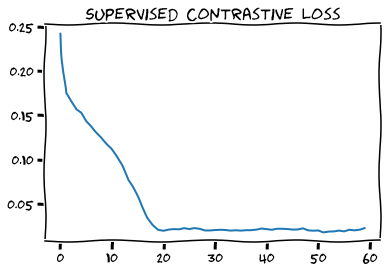

In [0]:
wandb.init(project="scl", entity="authors", id="supervised-contrastive-flowers-adam")
EPOCHS = 60
LOG_EVERY = 10
train_loss_results = []

start = time.time()
for epoch in tqdm(range(EPOCHS)):	
	epoch_loss_avg = tf.keras.metrics.Mean()
	
	for (images, labels) in train_ds:
		loss = train_step(images, labels)
		epoch_loss_avg.update_state(loss) 

	train_loss_results.append(epoch_loss_avg.result())
	wandb.log({"supervised_contrastive_loss": epoch_loss_avg.result()})

	if epoch % LOG_EVERY == 0:
		print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

end = time.time()
wandb.log({"training_time": end - start})

with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()

Loss gets saturated. But remember we did not do any augmentation here. 

## Supervised training

In [0]:
validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

In [0]:
def supervised_model():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	encoder_r.trainable = False

	r = encoder_r(inputs, training=False)
	outputs = Dense(5)(r)

	supervised_model = Model(inputs, outputs)

	return supervised_model

In [0]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=["accuracy"])

wandb.init(project="scl", entity="authors", id="flowers-fully-supervised")
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
	restore_best_weights=True, verbose=2)

supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=50,
	callbacks=[WandbCallback(), es])

Epoch 1/50
49/49 [==============================] - 11s 233ms/step - loss: 1.1249 - accuracy: 0.9397 - val_loss: 0.9705 - val_accuracy: 0.7745
Epoch 2/50
49/49 [==============================] - 10s 206ms/step - loss: 0.5319 - accuracy: 0.9734 - val_loss: 0.7502 - val_accuracy: 0.7745
Epoch 3/50
49/49 [==============================] - 10s 195ms/step - loss: 0.3132 - accuracy: 0.9728 - val_loss: 0.6903 - val_accuracy: 0.7745
Epoch 4/50
49/49 [==============================] - 10s 198ms/step - loss: 0.2275 - accuracy: 0.9724 - val_loss: 0.6761 - val_accuracy: 0.7764
Epoch 5/50
49/49 [==============================] - 9s 183ms/step - loss: 0.1866 - accuracy: 0.9724 - val_loss: 0.6768 - val_accuracy: 0.7764
Epoch 6/50
49/49 [==============================] - 9s 185ms/step - loss: 0.1639 - accuracy: 0.9734 - val_loss: 0.6820 - val_accuracy: 0.7800
Epoch 00006: early stopping


## No `EarlyStopping`

In [0]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=["accuracy"])

wandb.init(project="scl", entity="authors", id="flowers-fully-supervised-no-es")

supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=50,
	callbacks=[WandbCallback()])

Epoch 1/50
49/49 [==============================] - 11s 216ms/step - loss: 1.1282 - accuracy: 0.9433 - val_loss: 0.9705 - val_accuracy: 0.7818
Epoch 2/50
49/49 [==============================] - 9s 192ms/step - loss: 0.5322 - accuracy: 0.9728 - val_loss: 0.7500 - val_accuracy: 0.7764
Epoch 3/50
49/49 [==============================] - 9s 193ms/step - loss: 0.3133 - accuracy: 0.9731 - val_loss: 0.6900 - val_accuracy: 0.7727
Epoch 4/50
49/49 [==============================] - 9s 193ms/step - loss: 0.2277 - accuracy: 0.9728 - val_loss: 0.6760 - val_accuracy: 0.7764
Epoch 5/50
49/49 [==============================] - 9s 182ms/step - loss: 0.1869 - accuracy: 0.9724 - val_loss: 0.6760 - val_accuracy: 0.7782
Epoch 6/50
49/49 [==============================] - 9s 181ms/step - loss: 0.1643 - accuracy: 0.9728 - val_loss: 0.6816 - val_accuracy: 0.7800
Epoch 7/50
49/49 [==============================] - 9s 182ms/step - loss: 0.1504 - accuracy: 0.9734 - val_loss: 0.6886 - val_accuracy: 0.7800
Epoch

## Higher learning rate + No `EarlyStopping`

In [0]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=tf.keras.optimizers.Adam(lr=0.1),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=["accuracy"])

wandb.init(project="scl", entity="authors", id="flowers-fully-supervised-no-es-high-lr")

supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=50,
	callbacks=[WandbCallback()])

Epoch 1/50
49/49 [==============================] - 11s 217ms/step - loss: 0.2646 - accuracy: 0.9535 - val_loss: 1.3420 - val_accuracy: 0.7764
Epoch 2/50
49/49 [==============================] - 10s 198ms/step - loss: 0.1774 - accuracy: 0.9689 - val_loss: 1.2380 - val_accuracy: 0.7527
Epoch 3/50
49/49 [==============================] - 9s 186ms/step - loss: 0.1556 - accuracy: 0.9705 - val_loss: 1.2831 - val_accuracy: 0.7309
Epoch 4/50
49/49 [==============================] - 9s 189ms/step - loss: 0.1706 - accuracy: 0.9692 - val_loss: 1.5223 - val_accuracy: 0.7636
Epoch 5/50
49/49 [==============================] - 9s 188ms/step - loss: 0.1764 - accuracy: 0.9679 - val_loss: 1.4522 - val_accuracy: 0.7491
Epoch 6/50
49/49 [==============================] - 9s 187ms/step - loss: 0.1628 - accuracy: 0.9699 - val_loss: 1.5781 - val_accuracy: 0.7309
Epoch 7/50
49/49 [==============================] - 9s 187ms/step - loss: 0.1629 - accuracy: 0.9692 - val_loss: 1.4247 - val_accuracy: 0.7564
Epoc

## Lower learning rate + No `EarlyStopping`

In [0]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=["accuracy"])

wandb.init(project="scl", entity="authors", id="flowers-fully-supervised-no-es-low-lr")

supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=50,
	callbacks=[WandbCallback()])

Epoch 1/50
49/49 [==============================] - 11s 215ms/step - loss: 1.1428 - accuracy: 0.9205 - val_loss: 0.9783 - val_accuracy: 0.7745
Epoch 2/50
49/49 [==============================] - 10s 194ms/step - loss: 0.5380 - accuracy: 0.9724 - val_loss: 0.7534 - val_accuracy: 0.7745
Epoch 3/50
49/49 [==============================] - 10s 195ms/step - loss: 0.3157 - accuracy: 0.9728 - val_loss: 0.6915 - val_accuracy: 0.7709
Epoch 4/50
49/49 [==============================] - 10s 195ms/step - loss: 0.2288 - accuracy: 0.9728 - val_loss: 0.6767 - val_accuracy: 0.7764
Epoch 5/50
49/49 [==============================] - 9s 187ms/step - loss: 0.1875 - accuracy: 0.9724 - val_loss: 0.6773 - val_accuracy: 0.7745
Epoch 6/50
49/49 [==============================] - 9s 182ms/step - loss: 0.1646 - accuracy: 0.9731 - val_loss: 0.6820 - val_accuracy: 0.7800
Epoch 7/50
49/49 [==============================] - 9s 182ms/step - loss: 0.1507 - accuracy: 0.9731 - val_loss: 0.6892 - val_accuracy: 0.7800
Ep